### imports

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, GroupShuffleSplit
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle
import os


### load training and testing sets

In [2]:
#if loaded train file exists
try:
    with open('data/train-data.pickle', 'rb') as handle:
        train = pickle.load(handle)
#if not load and save
except:
    !unzip data/training_set_VU_DM.csv.zip
    train = pd.read_csv('training_set_VU_DM.csv')
    !rm training_set_VU_DM.csv
    with open('data/train-data.pickle', 'wb') as handle:
        pickle.dump(train, handle)

#if loaded test file exists
try:
    with open('data/test-data.pickle', 'rb') as handle:
        test = pickle.load(handle)
#if not load and save
except:
    !unzip data/test_set_VU_DM.csv.zip
    test = pd.read_csv('test_set_VU_DM.csv')
    !rm test_set_VU_DM.csv
    with open('data/test-data.pickle', 'wb') as handle:
        pickle.dump(test, handle)

## Functions

### Submission

In [3]:
def create_submission(test_data, property_predicted_score, head=''):
    !mv submission.csv.zip prev.submission.zip
    test_data['raiting'] = property_predicted_score
    submition_data = test_data[['srch_id','prop_id','raiting']]
    submition_data = submition_data.sort_values(by=['srch_id', 'raiting'], ascending=[True,  False])
    submition_data = submition_data.drop(columns="raiting")
    file_name = head+'submission.csv'
    submition_data.to_csv(file_name, index=False)
    
    cmd = 'zip ' + file_name +'.zip ' + file_name
    os.system(cmd)
    os.system('rm ' + file_name)


### Ranking

In [4]:
def grades(data_frame):
    return data_frame['click_bool'] + data_frame['booking_bool']*4 #if booked then clicked, booked = 5

def target_function(data_frame):
    #lklhd = hotel_booking_likelihood(data_frame)
    #data_frame_out = data_frame.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    
    #x = data_frame['lklhd'].values #0.26-0.28
    #x = grades(data_frame) + data_frame['lklhd'].values #same as grading 1 click 5 book
    #x = grades(data_frame) 
    x = data_frame['grades'] 
    
    #x = (data_frame['click_bool'] + data_frame['booking_bool']*4)*np.log2(data_frame['position'] + 2) + data_frame['lklhd'].values
    #x = (data_frame['click_bool'] + 4*data_frame['booking_bool'])*(data_frame['position'] + 1)*(1+data_frame['lklhd'].values)#*(data_frame['gross_bookings_usd']+1) 

    return x

def discountedCumulativeGain(result, k=5):
    """
    Evaluated per query
    taken from 
    https://towardsdatascience.com/normalized-discounted-cumulative-gain-37e6f75090e9
    """
    dcg = []
    for idx, val in enumerate(result[0:k]): 
        #numerator = (2**val) - 1
        numerator = val
        # add 2 because python 0-index
        denominator =  np.log2(idx + 2) 
        score = numerator/denominator
        dcg.append(score)
    return sum(dcg)


def NDCG_at_k(X, ranking, grades, k=5, verbose=True):
    d = {'srch_id': X['srch_id'], 'ranking': ranking, 'grades': grades}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by=['srch_id', 'ranking'], ascending=[True,  False])

    NDCG  = df.groupby('srch_id').aggregate\
    (ndcg=("grades", lambda x: discountedCumulativeGain(x, k)))

    df = df.sort_values(by=['srch_id', 'grades'], ascending=[True,  False])
    INDCG  = df.groupby('srch_id').aggregate\
    (indcg=("grades", lambda x: discountedCumulativeGain(x, k)))
    INDCG = INDCG[INDCG['indcg']!=0]
    x = NDCG['ndcg']/INDCG['indcg']# true ranking has the information regarding actual booking
    
    if verbose:
        print(f'ndcg_@{k} {x.mean()}')

    return x.mean()
# unit tests
d = {'srch_id': [1, 1, 1, 1, 1, 1]}
df = pd.DataFrame(data=d)
ndcg_score = NDCG_at_k(df, ranking=[5, 0, 0, 0, 0, 0], grades=[0, 0, 5, 0, 0, 0], k=5)

#assert discountedCumulativeGain([0,0,5], k=5)==((2**5-1)/np.log2(4) ) , "assertion discountedCumulativeGain wrong"
assert discountedCumulativeGain([0,0,5], k=5)==(5/np.log2(4) ) , "assertion discountedCumulativeGain wrong"
assert ndcg_score == (5/np.log2(4))/5 , "assertion ndcg wrong"


ndcg_@5 0.5


### Cross validation and model fit

In [5]:
def evaluate_model(model, X_train=[], X_test=[], features_to_choose=[], plot=False, is_ranker=False):
    
    rankings = my_fit_and_predict(model, X_train=X_train, X_test=X_test, \
                                  features_to_choose=features_to_choose, plot=plot, is_ranker=is_ranker)
    
    graded_relevance = X_test['grades']
    
    ndcg_score = NDCG_at_k(X_test, ranking=rankings, grades=graded_relevance, k=5, verbose=False)
    return ndcg_score

def my_fit_and_predict(model, X_train=[], X_test=[], features_to_choose=[], plot=False, is_ranker=False):
    
    Y = X_train['grades']
    X_train, X_test = join_test_and_train_Kfold(train=X_train, test=X_test,n_splits=5)

    if is_ranker:
        model.fit(X_train[features_to_choose], Y, qid=X_train['srch_id'])
    else:
        model.fit(X_train[features_to_choose], Y)
        
    if plot:
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + 0.5
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.barh(pos, feature_importance[sorted_idx], align="center")
        plt.yticks(pos, np.array(features_to_choose)[sorted_idx])
        plt.title("Feature Importance (MDI)")

    rankings = model.predict(X_test[features_to_choose])

    return rankings 


def my_cross_validation(model, X=[], features_to_choose=[], n_splits=5, is_ranker=False):
    ndcg_score = 0
    
    group_kfold = GroupKFold(n_splits=n_splits)
    
    for tr_indx, val_idx in group_kfold.split(X=X, groups=X['srch_id']):
        X_train, X_valid = X.iloc[tr_indx, :], X.iloc[val_idx, :]
        ndcg_score += evaluate_model(model, X_train, X_valid, features_to_choose, is_ranker=is_ranker)
    
    average = ndcg_score/n_splits
    print(f'cross_validation average {average}')
    return average


### Target and Likelihood

In [47]:
def KFoldTargetEncoderTest(X=[], n_splits=5 ):
    group_kfold = GroupKFold(n_splits=n_splits)
    kfold_mean_name = 'kfold_lklhd'
    target = 'grades'
    feature = 'prop_id'
    
    X.loc[:, kfold_mean_name] = np.nan
    mean_of_target = X[target].mean()
 
    kfold_split = group_kfold.split(X=X, groups=X['srch_id'])

    for tr_ind, val_ind in kfold_split:
        X_tr  = X.iloc[tr_ind]
        X_val = X.iloc[val_ind]
        #print('asignment')
        X.loc[X.index[val_ind], kfold_mean_name] = X_val[feature].map(X_tr.groupby(feature)[target].mean())
        #print(len(a))
        #print(len(val_ind))
        #X.iloc[list(val_ind), col_mean_name] = a
        #print('after assignment')
        X[kfold_mean_name] = X[kfold_mean_name].fillna(mean_of_target)
        #print('after fillna')
    #print('return X')
    return X

def join_test_and_train_Kfold(train=[], test=[],n_splits=5):
    col_mean_name = 'kfold_lklhd'
    feature = 'prop_id'
       
    train_out = KFoldTargetEncoderTest(X=train, n_splits=n_splits )
    kfold_lklhd = train_out.groupby(feature)[col_mean_name].mean().reset_index() 

    mean_of_target = train_out[col_mean_name].mean()
    test_out = test.merge(kfold_lklhd, how='left', left_on=feature, right_on=feature)
    test_out[col_mean_name].fillna(mean_of_target, inplace = True)

    return train_out, test_out

train_unit = pd.DataFrame({'srch_id':[1,1,1,2,2,2,3,3,3,4,4,4], 
                           'prop_id':[1,2,4,1,2,3,1,2,3,1,2,3],
                      'booking_bool':[1,0,0,1,0,0,0,0,1,0,0,1],
                        'click_bool':[1,0,1,1,0,0,0,0,1,1,0,0]})
train_unit['grades'] = grades(train_unit)
train_unit_2 = train_unit.copy()

#aa = KFoldTargetEncoderTest(X=train_unit, n_splits=2 )

a, b = join_test_and_train_Kfold(train=train_unit, test=train_unit_2, n_splits=2)
#display(a)

In [7]:


def hotel_booking_likelihood(data_frame=[]):
    """"""
    lklhd = data_frame.groupby('prop_id').sum().reset_index()
    lklhd = lklhd[['prop_id','booking_bool', 'click_bool']]
    
    lklhd['lklhd'] = lklhd['booking_bool'] + lklhd['click_bool']
    
    counts = data_frame.groupby('prop_id').size().reset_index(name='counts')
    
    # normalize by total counts of total amounts prop_id
    lklhd['lklhd'] = lklhd['lklhd']/counts['counts']
    lklhd.drop(columns=['booking_bool', 'click_bool'], inplace=True)
 
    return lklhd

def cross_hotel_booking_likelihood(train_frame, test_frame):
    x = test['prop_id']
    y = train['prop_id']
    common = set(x).intersection(set(y))
    
    lklhd = hotel_booking_likelihood(data_frame=train_frame)
    
    x = train_frame['prop_id']
    y = test_frame['prop_id']
    
    # evaluate the likelihood only for the interesection of hotels
    common = list(set(x).intersection(set(y)))
    commonDf = pd.DataFrame({'prop_id':common})
    
    lklhd_intersection = commonDf.merge(lklhd, how='left', left_on='prop_id', right_on='prop_id')
    
    train_frame_out = train_frame.merge(lklhd_intersection, how='left', left_on='prop_id', right_on='prop_id')
    test_frame_out = test_frame.merge(lklhd_intersection, how='left', left_on='prop_id', right_on='prop_id')
    
    #apply value to "nones" values
    median_lklhd = test_frame_out['lklhd'].median()
    
    mask  = test_frame_out['lklhd'].isnull()
    test_frame_out.loc[mask, 'lklhd'] =  median_lklhd
    mask  = train_frame_out['lklhd'].isnull()
    train_frame_out.loc[mask, 'lklhd'] = median_lklhd
    
    assert len(test_frame_out)==len(test_frame)
    assert len(train_frame_out)==len(train_frame)
    assert test_frame_out['lklhd'].isnull().sum() == 0
    return train_frame_out, test_frame_out


# unit tests
train_unit = pd.DataFrame({'srch_id':[1,1,1,2,2,2,3,3,3], 
                           'prop_id':[1,2,3,1,2,3,1,2,3],
                      'booking_bool':[1,0,0,1,0,0,0,0,1],
                        'click_bool':[1,0,1,1,0,0,0,0,1]})

test_unit = pd.DataFrame({'srch_id':[1,1,1,2,2,2,3,3,3], 
                          'prop_id':[1,2,4,1,2,4,1,2,4],
                     'booking_bool':[1,0,0,1,0,0,0,0,1],
                       'click_bool':[1,0,1,1,0,0,0,0,1]})

lklhd = hotel_booking_likelihood(data_frame=train_unit)
#display(lklhd)
#display(train_unit)
mask=train_unit['prop_id']==1
#display(train_unit[mask])
assert lklhd.loc[0, 'lklhd'] == 4/3
assert lklhd.loc[2, 'lklhd'] == 1

train_unit_out, test_unit_out = cross_hotel_booking_likelihood(train_unit, test_unit)
#display(train_unit_out)

assert train_unit_out.loc[2, 'lklhd'] == 2/3#median value
assert test_unit_out.loc[2, 'lklhd'] == 2/3

train_unit['grades'] = grades(train_unit)
#a = KFoldTargetEncoderTest(X=train_unit)

#b = join_test_and_train_Kfold(train=a, test=test_unit )





### features engeneering

In [8]:
def features_engeneering(data_frame):
    data_frame['month'] = pd.DatetimeIndex(pd.to_datetime(data_frame['date_time'])).month
    data_frame = data_frame.sort_values(by=['srch_id', 'price_usd'], ascending=[True,  False]).reset_index(drop=True)
    data_frame['price_order'] = data_frame.groupby('srch_id').cumcount()

    for i in ['orig_destination_distance']:
        data_frame[i] = data_frame[i].fillna(100)#(data_frame[i].max())
    
    for i in ['prop_review_score', 'prop_location_score2']:#, 'comp1_rate', 'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 'comp6_rate', 'comp7_rate', 'comp8_rate']:
        data_frame[i] = data_frame[i].fillna(-1)
    
     
    data_frame = is_cheaper(data_frame)
    
    min_affinity = data_frame['srch_query_affinity_score'].min()
    data_frame['srch_query_affinity_score'] = data_frame['srch_query_affinity_score'].fillna(min_affinity)
    
    
    average_user_usd = data_frame['visitor_hist_adr_usd'].mean()
    average_user_starrating = data_frame['visitor_hist_starrating'].mean()
    #data_frame['visitor_hist_adr_usd'] = \
    #data_frame['visitor_hist_adr_usd'].fillna(average_user_usd)
    #data_frame['visitor_hist_starrating'] = \
    #data_frame['visitor_hist_starrating'].fillna(average_user_starrating)
    
    data_frame['delta_starrating'] = np.abs(data_frame['visitor_hist_starrating'] - data_frame['prop_starrating'])
    data_frame['delta_usd'] = np.abs(data_frame['visitor_hist_adr_usd'] - data_frame['price_usd'])
    data_frame['delta_starrating'] = data_frame['delta_starrating'].fillna(0)
    data_frame['delta_usd'] = data_frame['delta_usd'].fillna(0)
    
    price_per_country_median = data_frame.groupby('prop_country_id').median().reset_index()
    price_per_country_median = price_per_country_median[['prop_country_id','price_usd']]
    price_per_country_median = price_per_country_median.rename(columns={"price_usd": "price_per_country_median"})
    
    price_per_query_max = data_frame.groupby('srch_id').max().reset_index()
    price_per_query_max = price_per_query_max[['srch_id','price_usd']]
    price_per_query_max = price_per_query_max.rename(columns={"price_usd": "price_per_query_max"})

    data_frame = data_frame.merge(price_per_country_median, how='left', left_on='prop_country_id', right_on='prop_country_id')
    data_frame = data_frame.merge(price_per_query_max, how='left', left_on='srch_id', right_on='srch_id')
    
    # apply maximum price for missing values
    mask = data_frame['price_usd'] == 0
    data_frame.loc[mask, 'price_usd'] = data_frame.loc[mask, 'price_per_query_max']
    
    mask_log_0 = data_frame['prop_log_historical_price']==0 #no data assume same price
 
    data_frame['delta_log_price'] = np.log(data_frame['price_usd']) - data_frame['prop_log_historical_price']
    data_frame.loc[mask_log_0, 'delta_log_price'] = 0
     
    # normalization
    data_frame['price_usd_normalized'] = data_frame['price_usd']/data_frame['price_per_country_median']
    
    # normalise by number of persons
    number_of_person = (data_frame['srch_adults_count'] + data_frame['srch_children_count']/2)
    data_frame['price_per_person'] = data_frame['price_usd']/number_of_person
    
    return data_frame

def undersample(data_frame, number_of_lines):
    """ 
    Keeps first number_of_lines in the 
    group srch_id and removes the rest"""
    data_frame = data_frame.sort_values(by=['srch_id', 'booking_bool', 'click_bool'], ascending=[True,  False, False]).reset_index(drop=True)
    df = data_frame[['srch_id']]
    x = df.groupby('srch_id').cumcount()# cummulative counting of group members
    data_frame.loc[:, 'group_index'] = x
    mask = data_frame['group_index']<number_of_lines
    data_frame = data_frame[mask]
    data_frame = data_frame.reset_index(drop=True)
    data_frame = data_frame.sort_values(by=['srch_id', 'booking_bool', 'click_bool'], ascending=[True,  False, False]).reset_index(drop=True)
    data_frame.drop(columns='group_index', inplace=True)

    return data_frame

""" unit test undersample """
data_frame_test = pd.DataFrame({ 'prop_id' : range(1, 11),\
                                'srch_id':[1, 1, 1, 1, 1, 1, 2, 2, 2, 2], \
                          'booking_bool': [0, 0, 0, 0, 0 ,1, 0, 0, 0, 0],
                            'click_bool': [0, 0, 0, 0, 1 ,1, 0, 0, 1, 0]})
df_test_out = pd.DataFrame({'prop_id' : [6, 5, 1, 2, 9, 7, 8, 10 ],
                             'srch_id': [1, 1, 1, 1 ,2, 2, 2, 2], 
                        'booking_bool': [1, 0, 0, 0, 0 ,0, 0, 0], 
                          'click_bool': [1, 1, 0, 0, 1 ,0, 0, 0]})
def is_cheaper(df):
    #+1 if Expedia has a lower price than competitor ; 0 if the same; -1 if Expedia’s
    #price is higher than competitor 1; null signifies there is no competitive data
    
    # Drop all other comp columns, except for "rate"
    df = df.drop(df.filter(regex='(comp._inv|comp._rate.+)').columns, axis=1)
    # Create new col
    df['comp_cheaper'] = np.nan
    df_filter_comp = df.filter(regex='comp') 
    df['comp_cheaper'] = df['comp_cheaper'].mask((df_filter_comp == 0).any(axis=1),0).mask((df_filter_comp > 0).any(axis=1), 1).mask((df_filter_comp<0).any(axis=1), -1)
    # Drop old comp cols
    df = df.drop(df.filter(regex='comp._rate').columns, axis=1)
    df['comp_cheaper'] = df['comp_cheaper'].fillna(0)
    return df


df = pd.DataFrame({'comp1_rate':[0, 0, 0, 0 ],'comp2_rate': [1 ,-1, 1, 0], 'comp3_rate':[-1, 0, 0, np.nan]})

df=is_cheaper(df)

#display(df)

assert df['comp_cheaper'].loc[0]==-1
assert df['comp_cheaper'].loc[1]==-1
assert df['comp_cheaper'].loc[2]==1
assert df['comp_cheaper'].loc[3]==0

df_out = undersample(data_frame_test, 4)                             
check = df_test_out==df_out
assert check.values.prod()==True, 'undersample failed'



### Total columns

In [9]:
train['grades'] = grades(train)

train_amount = len(train)
print(f'train length: {train_amount}')
print(f'test length: {len(test)}')
mask = train['booking_bool']==True
booked_amount = len(train[mask])
print(f'booked amount: {booked_amount}')
mask = (train['booking_bool']==False) & (train['click_bool']==True)
clicked_amount = len(train[mask])
print(f'clicked but not booked: {clicked_amount}')
print(f'total/booked: {train_amount/booked_amount}')
print(f'columns: {len(train.columns)}')


train length: 4958347
test length: 4959183
booked amount: 138390
clicked but not booked: 83489
total/booked: 35.82879543319604
columns: 55


### Total null columns and filling nulls in train

In [10]:
mask = train['booking_bool'] == True
train.loc[mask,['prop_location_score1', 'prop_location_score2']].max()

prop_location_score1    6.97
prop_location_score2    1.00
dtype: float64

## Parameters
defines parameters for running the training and predictions

In [11]:
max_price_usd = train['price_usd'].median() + train['price_usd'].std()*5
max_price_usd = 1e9
keep_first_lines = 5
perform_undersampling = False
perform_submission = True
number_of_splits = 5

print(f'max allowed price {max_price_usd} $')
print(f'perform_submission {perform_submission} ')
print(f'perform_undersampling {perform_undersampling} ')


max allowed price 1000000000.0 $
perform_submission True 
perform_undersampling False 


### Amount of hotels in data sets

In [12]:
x = test['prop_id']
y = train['prop_id']
unique_test = set(x) - set(y)
unique_train = set(y) - set(x)
common = set(x).intersection(set(y))
print(f'Amount of hotels in test data {len(set(x))} ')
print(f'Amount of hotels in train data {len(set(y))}')
print(f'Amount of unique hotels test {len(unique_test)}')
print(f'Amount of unique hotels train {len(unique_train)}')
print(f'Amount of common hotels in train and  test {len(common)}')

#train['prop_id']==unique


Amount of hotels in test data 129438 
Amount of hotels in train data 129113
Amount of unique hotels test 7773
Amount of unique hotels train 7448
Amount of common hotels in train and  test 121665


In [13]:
if False:
    tr, te = cross_hotel_booking_likelihood(train, test)
    x = tr['lklhd']#hotel_booking_likelihood(train)

    tr['lklhd'].hist(bins=30)
    tr['lklhd'].median()



In [14]:
print(train.isnull().sum())


srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

In [15]:
#train = train.sort_values(by=['srch_id'])
#test = test.sort_values(by=['srch_id'])

train_eng = features_engeneering(train)
test_eng = features_engeneering(test)

train_eng = train_eng.dropna(axis=1)


#train_eng = train_eng.sort_values(by=['srch_id'])
#test_eng = test_eng.sort_values(by=['srch_id'])


assert len(train_eng)==len(train)
assert len(test_eng)==len(test)

if perform_undersampling:
    train_eng = undersample(train_eng, keep_first_lines) 
    ## remove outliers from price
mask = train_eng['price_usd']<max_price_usd
train_eng = train_eng[mask]

a = set(train_eng.columns)
len(a)
b = set(test_eng.columns)
print(f'columns not in both sets {a-b}')




columns not in both sets {'click_bool', 'booking_bool', 'grades', 'position'}


12

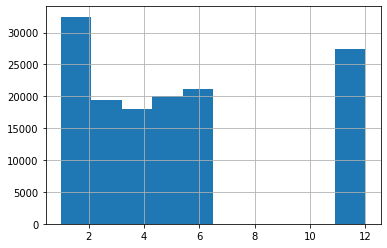

In [16]:
mask = train_eng['booking_bool']==True
train_eng.loc[mask, 'month'].hist()
train_eng['month'].max()

In [17]:
#display(train_eng[['month', 'delta_log_price', 'price_usd','booking_bool', 'price_order','price_per_country_median','price_per_query_max','price_per_person']].head(100))

### Choose features to fit

In [18]:
print(train_eng.columns)#  the columns after droping


features_to_choose = [#'srch_id', 
                      #'date_time',
                      #'site_id',
                      'visitor_location_country_id',
                      'prop_country_id',
                      #'prop_id',
                      'prop_starrating',
                      'prop_review_score',
                      'prop_brand_bool',
                      'prop_location_score1',
                      'prop_location_score2',
                      'prop_log_historical_price',
                      #'position',
                      'price_usd',
                      #'price_usd_normalized',
                      'promotion_flag',
                      'srch_destination_id',
                      'srch_length_of_stay',
                      'srch_booking_window',
                      'srch_adults_count',
                      'srch_children_count',
                      'srch_room_count',
                      'srch_saturday_night_bool',
                      'orig_destination_distance',
                      #'random_bool',
                      #'click_bool',
                      #'gross_bookings_usd',
                      #'booking_bool',
                      #'location_score',
                      #'historical_price',
                      #'price_per_country_median',
                      #'price_per_person'
                      'price_order',
                      #'lklhd',
                      #'month',
                      'kfold_lklhd',
                      'delta_log_price',
                      'comp_cheaper',
                      'delta_starrating',
                      'delta_usd',
                      #'srch_query_affinity_score'
                                             ]                        
missing_values = set(train_eng.columns) - set(features_to_choose)
print(f'not used fields {missing_values}')

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score',
       'prop_brand_bool', 'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'click_bool',
       'booking_bool', 'grades', 'month', 'price_order', 'comp_cheaper',
       'delta_starrating', 'delta_usd', 'price_per_country_median',
       'price_per_query_max', 'delta_log_price', 'price_usd_normalized',
       'price_per_person'],
      dtype='object')
not used fields {'price_per_person', 'prop_id', 'srch_query_affinity_score', 'random_bool', 'booking_bool', 'srch_id', 'grades', 'price_usd_normalized', 'site

## Test and Evaluate

In [19]:
loss_function = 'absolute_error'
loss_function = 'squared_error'
#{‘squared_error’, ‘absolute_error’, ‘huber’, ‘quantile’}

In [20]:
features_to_choose

['visitor_location_country_id',
 'prop_country_id',
 'prop_starrating',
 'prop_review_score',
 'prop_brand_bool',
 'prop_location_score1',
 'prop_location_score2',
 'prop_log_historical_price',
 'price_usd',
 'promotion_flag',
 'srch_destination_id',
 'srch_length_of_stay',
 'srch_booking_window',
 'srch_adults_count',
 'srch_children_count',
 'srch_room_count',
 'srch_saturday_night_bool',
 'orig_destination_distance',
 'price_order',
 'kfold_lklhd',
 'delta_log_price',
 'comp_cheaper',
 'delta_starrating',
 'delta_usd']

In [21]:
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit regression model
#model = linear_model.LinearRegression()
#n_neighbors = 10
#model = neighbors.KNeighborsRegressor(n_neighbors)
#model= DecisionTreeRegressor(random_state=0)
#model = GradientBoostingRegressor(random_state=0)

########       Cross EVALUATION           ###############


evaluation_set_size = 1/3
test_set_size = 0.4

gss = GroupShuffleSplit(test_size=test_set_size, n_splits=1, random_state = 7)
X_train_inds, X_test_inds = next(gss.split(train_eng, groups=train_eng['srch_id']))

X_train_temp = train_eng.iloc[X_train_inds]
X_test = train_eng.iloc[X_test_inds]

gss = GroupShuffleSplit(test_size=evaluation_set_size, n_splits=1, random_state = 7).split(X_train_temp, groups=X_train_temp['srch_id'])
X_train_inds, X_eval_inds = next(gss)

X_train = X_train_temp.iloc[X_train_inds]
X_eval = X_train_temp.iloc[X_eval_inds]

### XGB

In [22]:
import xgboost as xgb


### Ranker

In [23]:
to_optimize=True

/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.3738681088772523
The time of evaluation fit: 182.3324751853943


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.37407797864261527
The time of evaluation fit: 187.47473216056824


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.37359562383341666
The time of evaluation fit: 267.98764872550964


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.3742310708586397
The time of evaluation fit: 200.6388876438141
Optimal learning rate: 0.26
score: 0.3742310708586397


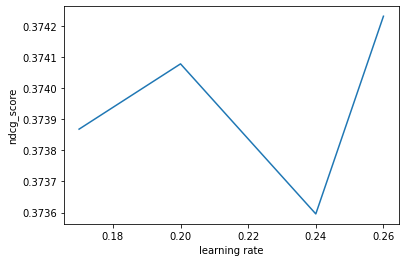

/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.37353255733875784
The time of evaluation fit: 126.58941578865051


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.37503755721553234
The time of evaluation fit: 152.0917637348175


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.3742310708586397
The time of evaluation fit: 184.67460942268372


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.3725496405367563
The time of evaluation fit: 217.79203152656555


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.36770028866675697
The time of evaluation fit: 324.69713163375854


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.36375203379826127
The time of evaluation fit: 295.72697257995605
Optimal depth: 5
score: 0.37503755721553234


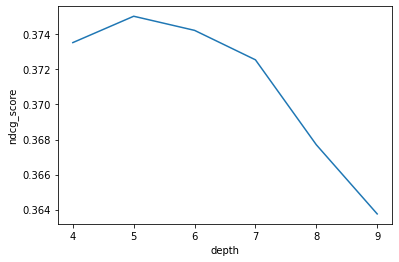

/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.37503755721553234
The time of evaluation fit: 158.38502073287964
Optimal child weight: 1
score: 0.37503755721553234


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.37422523368726657
The time of evaluation fit: 152.81655049324036
Optimal child weight: 1
score: 0.37503755721553234


/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

cross_validation average 0.3743858148617041
The time of evaluation fit: 157.98335456848145
Optimal child weight: 1
score: 0.37503755721553234


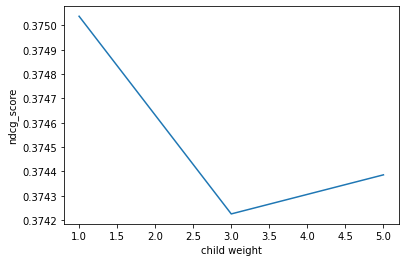

In [24]:
if to_optimize:
    x = []
    learning_rate = [0.17, 0.2, 0.24, 0.26]
    depth = [4,5,6,7,8,9]
    min_child_weight_i = [1,3,5]

    prev_ndgc = 0
    for i in learning_rate:
        start = time.time()
        ranker = xgb.XGBRanker(learning_rate=i, objective='rank:pairwise')
        ndcg_score = my_cross_validation(ranker, X=X_eval, \
                                         features_to_choose=features_to_choose, \
                                         n_splits=number_of_splits, \
                                         is_ranker=True)
        end = time.time()
        print("The time of evaluation fit:", end-start)
        x.append(ndcg_score)
        prev_ndgc=ndcg_score


    optimal_score_index = x.index(max(x))
    optimal_learnign_rate = learning_rate[optimal_score_index]
    print(f'Optimal learning rate: {optimal_learnign_rate}')
    print(f'score: {max(x)}')

    plt.plot(learning_rate[0:len(x)], x)
    plt.xlabel('learning rate')
    plt.ylabel('ndcg_score')
    plt.show()

    #depth optimization
    prev_ndgc = 0
    x=[]
    for i in depth:
        start = time.time()
        ranker = xgb.XGBRanker(learning_rate=optimal_learnign_rate, max_depth=i, objective='rank:pairwise')
        ndcg_score = my_cross_validation(ranker, X=X_eval, \
                                         features_to_choose=features_to_choose, \
                                         n_splits=number_of_splits, 
                                         is_ranker=True)
        end = time.time()
        print("The time of evaluation fit:", end-start)
        x.append(ndcg_score)
        #if ndcg_score<prev_ndgc:
        #    print('exit before the end')
        #    break    # break here
        prev_ndgc=ndcg_score

    optimal_score_index = x.index(max(x))
    optimal_depth = depth[optimal_score_index]
    print(f'Optimal depth: {optimal_depth}')
    print(f'score: {max(x)}')

    plt.plot(depth[0:len(x)], x)
    plt.xlabel('depth')
    plt.ylabel('ndcg_score')
    plt.show()
    
    #child
    x = []
    prev_ndgc = 0

    for i in min_child_weight_i:
        start = time.time()
        ranker = xgb.XGBRanker(learning_rate=optimal_learnign_rate, \
                               max_depth=optimal_depth, \
                               min_child_weight = i,\
                               objective='rank:pairwise')
        ndcg_score = my_cross_validation(ranker, X=X_eval, \
                                         features_to_choose=features_to_choose, \
                                         n_splits=number_of_splits, \
                                         is_ranker=True)
        end = time.time()
        print("The time of evaluation fit:", end-start)
        x.append(ndcg_score)
        prev_ndgc=ndcg_score

    optimal_score_index = x.index(max(x))
    optimal_child_weight = min_child_weight_i[optimal_score_index]
    print(f'Optimal child weight: {optimal_child_weight}')
    print(f'score: {max(x)}')

    plt.plot(min_child_weight_i[0:len(x)], x)
    plt.xlabel('child weight')
    plt.ylabel('ndcg_score')
    plt.show()

    
else:
    optimal_depth=6
    optimal_learnign_rate=0.2


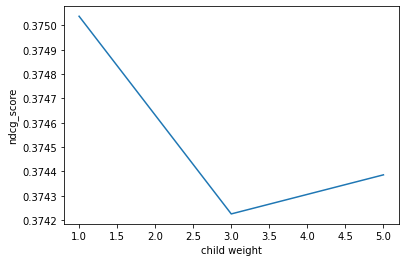

In [25]:
plt.plot(min_child_weight_i[0:len(x)], x)
plt.xlabel('child weight')
plt.ylabel('ndcg_score')
plt.show()

In [34]:
#optimal_child_weight = 1
optimal_learnign_rate = 0.2
optimal_depth = 7

print(optimal_child_weight)
print(optimal_learnign_rate)
print(optimal_depth)

1
0.2
7


In [35]:
#scale_pos_weight
start = time.time()
#ranker = xgb.XGBRanker(learning_rate=optimal_learnign_rate, max_depth=optimal_depth, objective='rank:pairwise')
ranker = xgb.XGBRanker(min_child_weight=optimal_child_weight, \
                       learning_rate=optimal_learnign_rate, \
                       max_depth=optimal_depth, objective='rank:pairwise')

ndcg_score = evaluate_model(ranker, X_train, X_test, features_to_choose, is_ranker=True)
end = time.time()
print(f'Validation time and score XGBRanking: {end-start}, {ndcg_score}')



/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/wolfson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

Validation time and score XGBRanking: 117.78389167785645, 0.3822842176126369


,visitor_location_country_id,prop_country_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,...,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,price_order,kfold_lklhd,delta_log_price,comp_cheaper,delta_starrating,delta_usd
visitor_location_country_id,1.000000,0.482787,-0.112911,0.064852,0.182405,-0.121392,-0.017589,-0.021898,-0.001791,-0.032065,...,0.012874,-0.027091,0.068939,0.089161,0.021390,-0.001293,0.008543,-0.023218,-0.038358,-0.035774
prop_country_id,0.482787,1.000000,-0.161729,0.094099,0.310493,-0.183344,-0.020074,-0.021119,-0.004450,-0.041365,...,0.057388,-0.011804,0.076750,-0.165758,0.032914,-0.002735,0.023370,-0.037382,-0.036197,-0.033943
prop_starrating,-0.112911,-0.161729,1.000000,0.304708,0.021329,0.287322,0.159868,0.167723,0.007770,0.173732,...,-0.031148,0.037151,-0.042530,0.099467,-0.318018,0.098725,-0.038032,0.016623,-0.050127,0.029961
prop_review_score,0.064852,0.094099,0.304708,1.000000,0.206421,0.110799,0.235101,0.126316,0.001379,0.058372,...,0.015157,0.015598,0.019556,-0.014134,-0.201274,0.105632,-0.004983,0.026877,-0.027254,-0.003267
prop_brand_bool,0.182405,0.310493,0.021329,0.206421,1.000000,-0.184617,-0.005032,0.001311,-0.000993,-0.118841,...,0.036102,0.021232,0.070321,-0.107851,-0.047726,0.032341,0.028757,-0.005396,-0.019497,-0.012479
prop_location_score1,-0.121392,-0.183344,0.287322,0.110799,-0.184617,1.000000,0.319421,0.113209,0.003369,0.180326,...,-0.020746,0.022457,-0.050374,0.126161,-0.008017,-0.007079,-0.069230,0.035387,-0.006121,0.015490
prop_location_score2,-0.017589,-0.020074,0.159868,0.235101,-0.005032,0.319421,1.000000,0.074118,0.001088,0.113007,...,0.018034,0.022464,-0.022638,0.043648,0.004031,0.100392,-0.050103,0.017457,-0.014053,0.002543
prop_log_historical_price,-0.021898,-0.021119,0.167723,0.126316,0.001311,0.113209,0.074118,1.000000,-0.000620,0.039050,...,-0.048204,0.000780,0.000501,0.033825,-0.092146,0.004168,-0.207972,0.001266,-0.004009,0.004553
price_usd,-0.001791,-0.004450,0.007770,0.001379,-0.000993,0.003369,0.001088,-0.000620,1.000000,0.001217,...,0.002528,-0.000703,-0.001896,-0.001521,-0.006992,-0.000321,0.101757,-0.000338,-0.001030,0.000038
promotion_flag,-0.032065,-0.041365,0.173732,0.058372,-0.118841,0.180326,0.113007,0.039050,0.001217,1.000000,...,-0.004519,0.011597,-0.044601,0.056238,0.110930,0.068328,-0.153741,0.082846,-0.014402,-0.001623


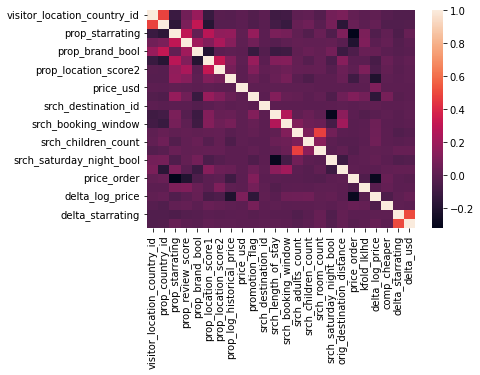

In [36]:
X_tr, X_te = join_test_and_train_Kfold(train=train_eng, test=test_eng,n_splits=5)

#dataplot=sns.heatmap(X_train.corr())
dataplot=sns.heatmap(X_tr[features_to_choose].corr(), xticklabels=True, yticklabels=True, cmap="YlGnBu")


In [44]:
features_to_choose = ['visitor_location_country_id',
 'prop_country_id',
 'prop_starrating',
 'prop_review_score',
 'prop_brand_bool',
 'prop_location_score1',
 'prop_location_score2',
 'prop_log_historical_price',
 'price_usd',
 'promotion_flag',
 'srch_destination_id',
 'srch_length_of_stay',
 'srch_booking_window',
 'srch_adults_count',
 'srch_children_count',
 'srch_room_count',
 'srch_saturday_night_bool',
 'orig_destination_distance',
 'price_order',
 'kfold_lklhd',
 'delta_log_price',
 'comp_cheaper',
 'delta_starrating',
 'delta_usd', 'relevance']

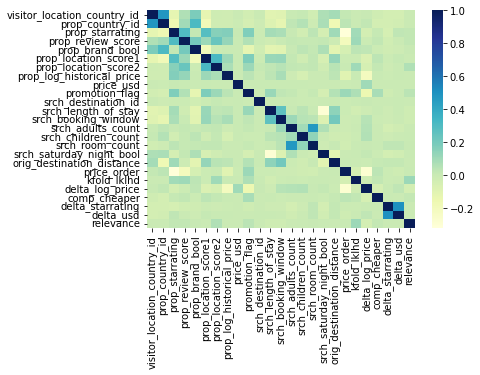

In [45]:
X_tr['relevance'] = grades(X_tr)
dataplot=sns.heatmap(X_tr[features_to_choose].corr(), xticklabels=True, yticklabels=True, cmap="YlGnBu")


In [46]:
X_tr[features_to_choose].corr()

,visitor_location_country_id,prop_country_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,...,srch_room_count,srch_saturday_night_bool,orig_destination_distance,price_order,kfold_lklhd,delta_log_price,comp_cheaper,delta_starrating,delta_usd,relevance
visitor_location_country_id,1.000000,0.482787,-0.112911,0.064852,0.182405,-0.121392,-0.017589,-0.021898,-0.001791,-0.032065,...,-0.027091,0.068939,0.089161,0.021390,-0.001293,0.008543,-0.023218,-0.038358,-0.035774,0.000805
prop_country_id,0.482787,1.000000,-0.161729,0.094099,0.310493,-0.183344,-0.020074,-0.021119,-0.004450,-0.041365,...,-0.011804,0.076750,-0.165758,0.032914,-0.002735,0.023370,-0.037382,-0.036197,-0.033943,-0.000575
prop_starrating,-0.112911,-0.161729,1.000000,0.304708,0.021329,0.287322,0.159868,0.167723,0.007770,0.173732,...,0.037151,-0.042530,0.099467,-0.318018,0.098725,-0.038032,0.016623,-0.050127,0.029961,0.024481
prop_review_score,0.064852,0.094099,0.304708,1.000000,0.206421,0.110799,0.235101,0.126316,0.001379,0.058372,...,0.015598,0.019556,-0.014134,-0.201274,0.105632,-0.004983,0.026877,-0.027254,-0.003267,0.026355
prop_brand_bool,0.182405,0.310493,0.021329,0.206421,1.000000,-0.184617,-0.005032,0.001311,-0.000993,-0.118841,...,0.021232,0.070321,-0.107851,-0.047726,0.032341,0.028757,-0.005396,-0.019497,-0.012479,0.008139
prop_location_score1,-0.121392,-0.183344,0.287322,0.110799,-0.184617,1.000000,0.319421,0.113209,0.003369,0.180326,...,0.022457,-0.050374,0.126161,-0.008017,-0.007079,-0.069230,0.035387,-0.006121,0.015490,-0.002053
prop_location_score2,-0.017589,-0.020074,0.159868,0.235101,-0.005032,0.319421,1.000000,0.074118,0.001088,0.113007,...,0.022464,-0.022638,0.043648,0.004031,0.100392,-0.050103,0.017457,-0.014053,0.002543,0.067515
prop_log_historical_price,-0.021898,-0.021119,0.167723,0.126316,0.001311,0.113209,0.074118,1.000000,-0.000620,0.039050,...,0.000780,0.000501,0.033825,-0.092146,0.004168,-0.207972,0.001266,-0.004009,0.004553,0.000197
price_usd,-0.001791,-0.004450,0.007770,0.001379,-0.000993,0.003369,0.001088,-0.000620,1.000000,0.001217,...,-0.000703,-0.001896,-0.001521,-0.006992,-0.000321,0.101757,-0.000338,-0.001030,0.000038,0.000180
promotion_flag,-0.032065,-0.041365,0.173732,0.058372,-0.118841,0.180326,0.113007,0.039050,0.001217,1.000000,...,0.011597,-0.044601,0.056238,0.110930,0.068328,-0.153741,0.082846,-0.014402,-0.001623,0.038404


In [ ]:
start = time.time()
raitings  = my_fit_and_predict(ranker, train_eng, test_eng, features_to_choose, is_ranker=True)
end = time.time()
print("The time of final fit XGBRanking:", end-start)
create_submission(test_eng, raitings, 'XGBRanking')
assert len(raitings)==len(test)
print(features_to_choose)
#assert 0, print("stop before regressions")

### xgb regression

In [ ]:
modelXGBRegressor = xgb.XGBRegressor(eval_metric=["ndcg@5"])
# Fit the model using predictor X and response y.
start = time.time()
ndcg_score = evaluate_model(modelXGBRegressor, X_train, X_test, features_to_choose)
end = time.time()
print(f'Validation time and score modelXGBRegressor: {end-start}, {ndcg_score}')

In [ ]:
start = time.time()
raitings  = my_fit_and_predict(modelXGBRegressor, train_eng, test_eng, features_to_choose)
end = time.time()
print("The time of final fit XGBRegressor:", end-start)
create_submission(test_eng, raitings, 'XGBRegressor')
assert len(raitings)==len(test)
features_to_choose

In [ ]:
#assert 0

### RandomForestRegressor

#### cross validation

In [ ]:
x = []
depth = [x for x in range(3,15) if x % 2 != 0]
prev_ndgc = 0
for i in depth:
    start = time.time()
    model = RandomForestRegressor(max_depth=i, criterion=loss_function, random_state=0, n_jobs=-1)
    ndcg_score = my_cross_validation(model, X=X_eval, features_to_choose=features_to_choose, n_splits=number_of_splits)
    end = time.time()
    print("The time of evaluation fit:", end-start)
    x.append(ndcg_score)
    if ndcg_score<prev_ndgc:
        print('exit before the end')
        break    # break here
    prev_ndgc=ndcg_score
    
optimal_score_index = x.index(max(x))
optimal_depth = depth[optimal_score_index]
print(f'Optimal depth: {optimal_depth}')
print(f'score: {max(x)}')

plt.plot(depth[0:len(x)], x)
plt.xlabel('depth')
plt.ylabel('ndcg_score')
plt.show()

### GradientBoostingRegressor

In [ ]:
x = []
n_estimators = [20, 30, 40, 60, 70, 90, 100, 110, 120, 130]
prev_ndgc = 0
for i in n_estimators:
    start = time.time()
    model = GradientBoostingRegressor(loss=loss_function, n_estimators = i, random_state=0)
    ndcg_score = my_cross_validation(model, X_eval, \
                features_to_choose, n_splits=number_of_splits)
    end = time.time()
    print("The time of evaluation fit:", end-start)
    x.append(ndcg_score)
    if ndcg_score<prev_ndgc:
        print('exit before the end')
        break    # break here
    prev_ndgc=ndcg_score
    
optimal_score_index = x.index(max(x))
optimal_n = n_estimators[optimal_score_index]
print(f'Optimal n estimators: {optimal_n}')
print(f'score: {max(x)}')
plt.plot(n_estimators[0:len(x)], x)
plt.xlabel('n_estimators')
plt.ylabel('ndcg_score')
plt.show()


### Testing Random Forest

In [ ]:
##
start = time.time()
model_random_forest = RandomForestRegressor(max_depth=optimal_depth, criterion=loss_function, random_state=0, n_jobs=-1)
ndcg_score = evaluate_model(model_random_forest, X_train, X_test, features_to_choose)
end = time.time()
print(f'Validation time and score RandomForestRegressor: {end-start}, {ndcg_score}')

### Testing Gradient Boosting

In [ ]:
start = time.time()
model_gradient_boosting = GradientBoostingRegressor(n_estimators=optimal_n,loss=loss_function, random_state=0)
ndcg_score = evaluate_model(model_gradient_boosting, X_train, X_test, features_to_choose, plot=True)
end = time.time()
print(f'Validation time and score GradientBoostingRegressor: {end-start}, {ndcg_score}')

## Fit and submit 

In [ ]:
assert perform_submission

### GradientBoostingRegressor

In [ ]:
start = time.time()
raitings  = my_fit_and_predict(model_gradient_boosting, train_eng, test_eng, features_to_choose)
end = time.time()
print("The time of final fit GradientBoostingRegressor:", end-start)
create_submission(test_eng, raitings, 'GradientBoostingRegressor')
assert len(raitings)==len(test)
features_to_choose

### RandomForestRegressor

In [ ]:
start = time.time()
raitings = my_fit_and_predict(model_random_forest, train_eng, test_eng, features_to_choose)
end = time.time()
print("The time of final fit RandomForestRegressor:", end-start)
create_submission(test_eng, raitings, 'RandomForestRegressor')
assert len(raitings)==len(test)
features_to_choose

In [ ]:
len(raitings)

In [ ]:
display(raitings)

In [ ]:
features_to_choose